In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import math
from PIL import Image
import cv2


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import nibabel as nib
import os


In [24]:

image_path = r"C:\Users\rithv\OneDrive\Desktop\cnn_rnn_models\sca2_dti_cnn\implem\anat\control_ses1_anat_2d\sub-control01_ses-01_T1w.nii_sagittal_slice.png"  # Replace with the actual path to your image

image = Image.open(image_path)

width, height = image.size

print(f"Image dimensions: Width={width}, Height={height}")


Image dimensions: Width=160, Height=256


In [25]:


def load_images_from_directory(directory, fixed_width, fixed_height):
    image_data = []
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
      
        image = cv2.resize(image, (fixed_width, fixed_height))
        image_data.append(image)
    return np.array(image_data)


fixed_width = 160
fixed_height = 256


control_images = load_images_from_directory(r"C:\Users\rithv\OneDrive\Desktop\cnn_rnn_models\sca2_dti_cnn\implem\anat\control_ses1_anat_2d", fixed_width, fixed_height)
sca2ataxia_images = load_images_from_directory(r"C:\Users\rithv\OneDrive\Desktop\cnn_rnn_models\sca2_dti_cnn\implem\anat\sca2ataxia_ses1_anat_2d", fixed_width, fixed_height)





In [26]:
# N
control_images = control_images / 255.0
sca2ataxia_images = sca2ataxia_images / 255.0


In [27]:
from keras.utils import to_categorical


control_labels = np.zeros(len(control_images))
sca2ataxia_labels = np.ones(len(sca2ataxia_images))


labels = np.concatenate((control_labels, sca2ataxia_labels))


one_hot_labels = to_categorical(labels, num_classes=2)


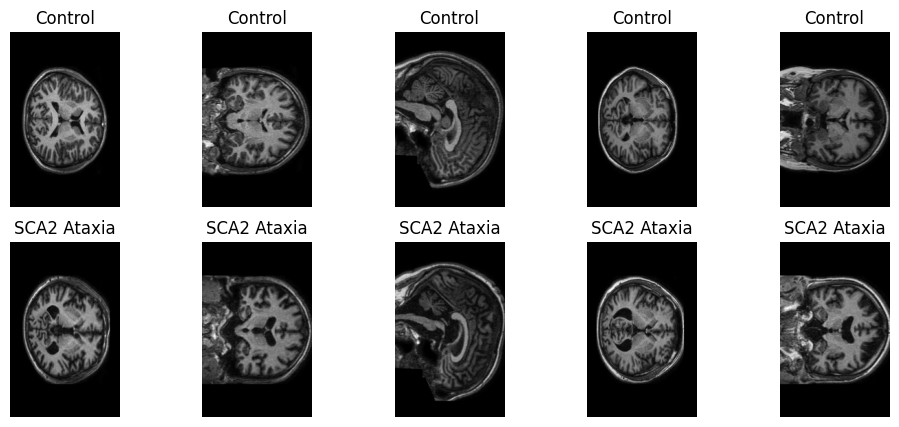

In [28]:


plt.figure(figsize=(12, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(control_images[i], cmap='gray')
    plt.title("Control")
    plt.axis('off')


for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(sca2ataxia_images[i], cmap='gray')
    plt.title("SCA2 Ataxia")
    plt.axis('off')

plt.show()


In [29]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    np.concatenate((control_images, sca2ataxia_images)),  # Concatenate both groups
    one_hot_labels,  # One-hot encoded labels
    test_size=0.2,  # 20% of the data for testing
    random_state=42  # Set a random seed for reproducibility
)


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotate images up to 20 degrees
    width_shift_range=0.2,  # Shift width by a fraction of the image width
    height_shift_range=0.2,  # Shift height by a fraction of the image height
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,  # Flip images vertically
    zoom_range=0.2,  # Zoom in/out by 20%
    shear_range=0.2,  # Shear transformations
    fill_mode='nearest'  # Fill in new pixels using the nearest available pixel
)
X_train = X_train.reshape(X_train.shape[0], 256, 160, 1)


datagen.fit(X_train)



In [31]:



def create_cnn_model(input_shape=(256, 160, 1)):
    model = keras.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),

        # Fully connected layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # 2 output classes: control and SCA2 Ataxia
    ])

    return model


model = create_cnn_model()


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#learning rate scheduler
def step_decay(epoch):
    initial_learning_rate = 0.001
    drop = 0.5
    epochs_drop = 10
    learning_rate = initial_learning_rate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return learning_rate

lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

#early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[lr_scheduler, early_stopping])



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
2/2 [==============================] - 4s 2s/step - loss: 0.9111 - accuracy: 0.6000 - val_loss: 0.7732 - val_accuracy: 0.3333 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
2/2 [==============================] - 2s 1s/step - loss: 0.7913 - accuracy: 0.4333 - val_loss: 0.6616 - val_accuracy: 0.6667 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
2/2 [==============================] - 2s 1s/step - loss: 0.6196 - accuracy: 0.6667 - val_loss: 0.6464 - val_accuracy: 0.6667 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
2/2 [==============================] - 2s 1s/step - loss: 0.5933 - accuracy: 0.6667 - val_loss: 0.6214 - val_accuracy: 0.6667 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
2/2 [==============================] - 2s 1s/step - loss: 0.5231

In [32]:
# Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1/1 [==============================] - 0s 164ms/step - loss: 0.5590 - accuracy: 0.6667
Test Loss: 0.559047520160675
Test Accuracy: 0.6666666865348816


1/1 [==============================] - 0s 75ms/step


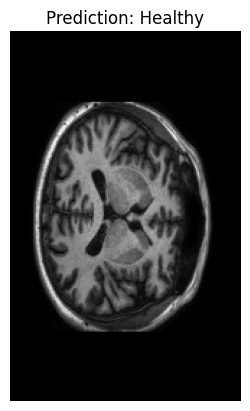

In [37]:


def predict_sca2ataxia(model, image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (160, 256))  
    image = image / 255.0 
    image = np.expand_dims(image, axis=-1) 

   
    prediction = model.predict(np.array([image]))

    
    plt.figure()
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.axis('off')
    if prediction[0][1] > 0.5:
        plt.title("Prediction: SCA2 Ataxia")
    else:
        plt.title("Prediction: Healthy")
    plt.show()

predict_sca2ataxia(model, r'C:\Users\rithv\OneDrive\Desktop\cnn_rnn_models\sca2_dti_cnn\implem\anat\control_ses1_anat_2d\sub-control11_ses-01_T1w.nii_axial_slice.png')